# Optimal power flow model in Julia

In [ ]:
import Pkg

# activate parent environment
Pkg.activate(normpath(joinpath(@__DIR__, ".")))
Pkg.resolve()
Pkg.instantiate()
Pkg.status()

using CSV
using DataFrames
using Dates
using CairoMakie
using JuMP

using Revise
using OptHP

  Activating project at `c:\Users\lange\OneDrive\Projects\2024\EEM25\Congestion-Management-based-on-Thermal-Comfort`
  No Changes to `C:\Users\lange\OneDrive\Projects\2024\EEM25\Congestion-Management-based-on-Thermal-Comfort\Project.toml`
    Updating `C:\Users\lange\OneDrive\Projects\2024\EEM25\Congestion-Management-based-on-Thermal-Comfort\Manifest.toml`
  [6fe1bfb0] + OffsetArrays v1.14.2
Precompiling project...
  ✓ OptHP
  1 dependency successfully precompiled in 4 seconds. 70 already precompiled.


Status `C:\Users\lange\OneDrive\Projects\2024\EEM25\Congestion-Management-based-on-Thermal-Comfort\Project.toml`
  [336ed68f] CSV v0.10.15
  [a93c6f00] DataFrames v1.7.0
  [2d871509] OptHP v1.0.0-DEV `OptHP`
  [295af30f] Revise v3.6.4


## Load data

In [9]:
network = CSV.read("data/network.csv", DataFrame)

# correct StarNode and EndNode for 1 based indexing
network.StartNode = network.StartNode .+ 1
network.EndNode = network.EndNode .+ 1

first(network, 5)

Row,StartNode,EndNode,Length,cable,Inom,R,X
,Int64,Int64,Float64,String7,Float64,Float64,Float64
1,48,16,22.21,50Al,0.12528,0.0142366,0.00188785
2,50,41,15.57,95Al,0.18386,0.0049824,0.00127674
3,27,42,18.26,95Al,0.18386,0.0058432,0.00149732
4,12,13,6.71,95Al,0.18386,0.0021472,0.00055022
5,13,28,6.52,95Al,0.18386,0.0020864,0.00053464


In [23]:
connections = CSV.read("data/user_connect.csv", DataFrame; delim=";")

# correct for 1 based indexing
connections.Node = connections.Node .+ 1

# convert PV (str) to Float64
connections.PV = parse.(Float64, replace.(connections.PV, "," => "."))

first(connections, 5)

Row,Column1,Name,Node.ID,Node.Unom,Length,Type short,Connection value,load,PV,HP,Node
,Int64,Int64,Int64,Int64,String7,String15,String7,Int64,Float64,Int64,Int64
1,1,871694840006284337,46559968,230,"21,75",XLPE 4x6Cu,3x25 A,7000,4.0,1,51
2,2,871694840006288793,46563894,230,"2,22",XLPE 4x6Cu,3x25 A,7000,6.0,0,52
3,3,871694840006284108,11195660,230,"10,4",PVC 4x16Al,1x35 A,2000,2.2,0,53
4,4,871694840006284115,11195660,230,"10,4",PVC 4x16Al,1x35 A,500,2.2,0,54
5,5,871694840006284092,2573422,230,"7,33",PVC 4x16Al,1x35 A,2000,2.2,0,55


In [11]:
loads_real = CSV.read("data/UserPower.csv", DataFrame)
loads_real.time = DateTime.(loads_real.time, "m/d/yyyy H:M p")

loads_reactive = CSV.read("data/UserReactivePower.csv", DataFrame)
loads_reactive.time = DateTime.(loads_reactive.time, "m/d/yyyy H:M p")

# Filter for rows where the date is February 1, 2024
date = Date(2024, 2, 1)
loads_real = loads_real[Date.(loads_real.time) .== date, 3:end]
loads_reactive = loads_reactive[Date.(loads_reactive.time) .== date, 3:end]
first(loads_real, 5)

Row,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0280492,0.0327633,0.00789328,0.00216432,0.00870451,0.0066902,0.0190303,0.0208217,0.0316786,0.00885476,0.00227458,0.0100109,0.00389288,0.00391422,0.0217207,0.00663473,0.0137514,0.038904,0.0160743,0.0134882,0.0108427,0.044233,0.00783649,0.00964245,0.0327462,0.0462532,0.0159094,0.0085621,0.0220982,0.00783409,0.00924792,0.0118713,0.025677,0.019321,0.0138463,0.0255821,0.0
2,0.0194261,0.0201885,0.00556897,0.00150743,0.00557323,0.00408914,0.0129535,0.0161562,0.0188356,0.00547041,0.00150153,0.00703371,0.00301253,0.00301947,0.0136849,0.00469629,0.0110687,0.0308354,0.0108854,0.0103217,0.00754248,0.0315925,0.00559041,0.00759827,0.0213481,0.0281427,0.0101261,0.00647718,0.0135207,0.00579418,0.00582512,0.00873516,0.018251,0.013007,0.00943072,0.0178395,0.0
3,0.0222562,0.0222175,0.00583958,0.00149652,0.00583324,0.0040186,0.0131774,0.0146778,0.0221186,0.0063148,0.00160216,0.00741227,0.00291713,0.00310672,0.0151385,0.00471799,0.0109297,0.0284821,0.0112424,0.00954143,0.00796256,0.0309558,0.00559076,0.00797005,0.0227603,0.0303833,0.0111911,0.0058502,0.0160791,0.00646978,0.00603232,0.00961901,0.0193459,0.0125066,0.00844744,0.0178119,0.0
4,0.0236077,0.0214192,0.00656782,0.00158927,0.00727005,0.00480448,0.0148979,0.0172582,0.021615,0.00741563,0.00154189,0.00765452,0.00309739,0.00323702,0.0160809,0.00554229,0.012016,0.0365018,0.0146685,0.0129499,0.00916666,0.0329395,0.00737826,0.00877966,0.0230161,0.0328368,0.0108052,0.00674518,0.0164615,0.00639536,0.00619007,0.0105051,0.0187594,0.0137561,0.010025,0.020322,0.0
5,0.0258527,0.026771,0.00830569,0.00182058,0.00881239,0.00562766,0.0188999,0.0181352,0.0267452,0.00775641,0.00204764,0.00959481,0.00368743,0.00390459,0.0200733,0.00636839,0.0138178,0.0417959,0.0160488,0.0146582,0.00963903,0.0412269,0.00812958,0.00960557,0.0266,0.0380806,0.0141561,0.00851961,0.0213948,0.00755007,0.00783836,0.0122754,0.0233571,0.0186267,0.0109073,0.0241358,0.0


## Build graph model

In [12]:
# Step 1: Identify all unique nodes
nodes = 0:maximum(vcat(network.EndNode, network.StartNode))
node_indices = Dict(node => i for (i, node) in enumerate(nodes))  # Map nodes to indices

# Step 2: Initialize an adjacency matrix
n = length(nodes)
adjacency_matrix = zeros(Int, n, n)

# Step 3: Populate the matrix with connections
for (start_node, end_node) in zip(network.StartNode, network.EndNode)
    j = node_indices[start_node]
    i = node_indices[end_node]
    adjacency_matrix[i, j] = 1
end

# this gives:
# --- StartNode ---
#   0, 1, 2, 3, ...
# 0 1, 0, 0, 0, ... 
# 1 0, 0, 1, 0, ...
# 2 0, 0, 0, 1, ...
df_adj = DataFrame(adjacency_matrix, string.(nodes))

# save as CSV
CSV.write("data/adjacency_matrix.csv", df_adj, delim=",")

"data/adjacency_matrix.csv"

## Construct GEC

In [38]:
model = GEC(network=network, 
            connections=connections, 
            loads_real=loads_real .* 1E-3, 
            loads_reactive=loads_reactive .* 1E-3,
)

Set parameter Username
Set parameter LicenseID to value 2599292
Academic license - for non-commercial use only - expires 2025-12-13


A JuMP Model
├ solver: Gurobi
├ objective_sense: MIN_SENSE
│ └ objective_function_type: JuMP.QuadExpr
├ num_variables: 65088
├ num_constraints: 113664
│ ├ JuMP.AffExpr in MOI.EqualTo{Float64}: 46176
│ ├ JuMP.AffExpr in MOI.GreaterThan{Float64}: 2400
│ ├ JuMP.AffExpr in MOI.LessThan{Float64}: 20064
│ ├ JuMP.QuadExpr in MOI.LessThan{Float64}: 8352
│ ├ JuMP.VariableRef in MOI.GreaterThan{Float64}: 27168
│ ├ JuMP.VariableRef in MOI.LessThan{Float64}: 8352
│ └ JuMP.VariableRef in MOI.ZeroOne: 1152
└ Names registered in the model
  └ :I, :J_hp, :J_loss, :J_pv, :P, :PLine, :P_hp, :P_hp_down, :P_pv, :P_pv_down, :Q, :QLine, :Q_hp, :Q_pv, :V, :z_hp

In [83]:
solution_summary(model)

* Solver : Gurobi

* Status
  Result count       : 8
  Termination status : OPTIMAL
  Message from the solver:
  "Model was solved to optimality (subject to tolerances), and an optimal solution is available."

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : 3.81961e+02
  Objective bound    : 3.81926e+02
  Relative gap       : 9.18872e-05
  Dual objective value : 3.81926e+02

* Work counters
  Solve time (sec)   : 3.91600e+01
  Simplex iterations : 98199
  Barrier iterations : 0
  Node count         : 1873


In [122]:
function prepare_solution(model)
    # prepare JuMP solution for plotting
    sol = Dict{Symbol, Vector{Float64}}()
    for var in [:I, :V, :P, :Q, :P_pv, :P_hp, :P_hp_down, :P_pv_down]
        sol[var] = vec(sum(Matrix{Float64}(value.(model[var]; result=1)), dims=2)) .* 1E3
    end

    # some solutions have to be corrected
    for var in [:P, :Q]
        sol[var] = sol[var] .* -1
    end
    return sol
end

prepare_solution (generic function with 1 method)

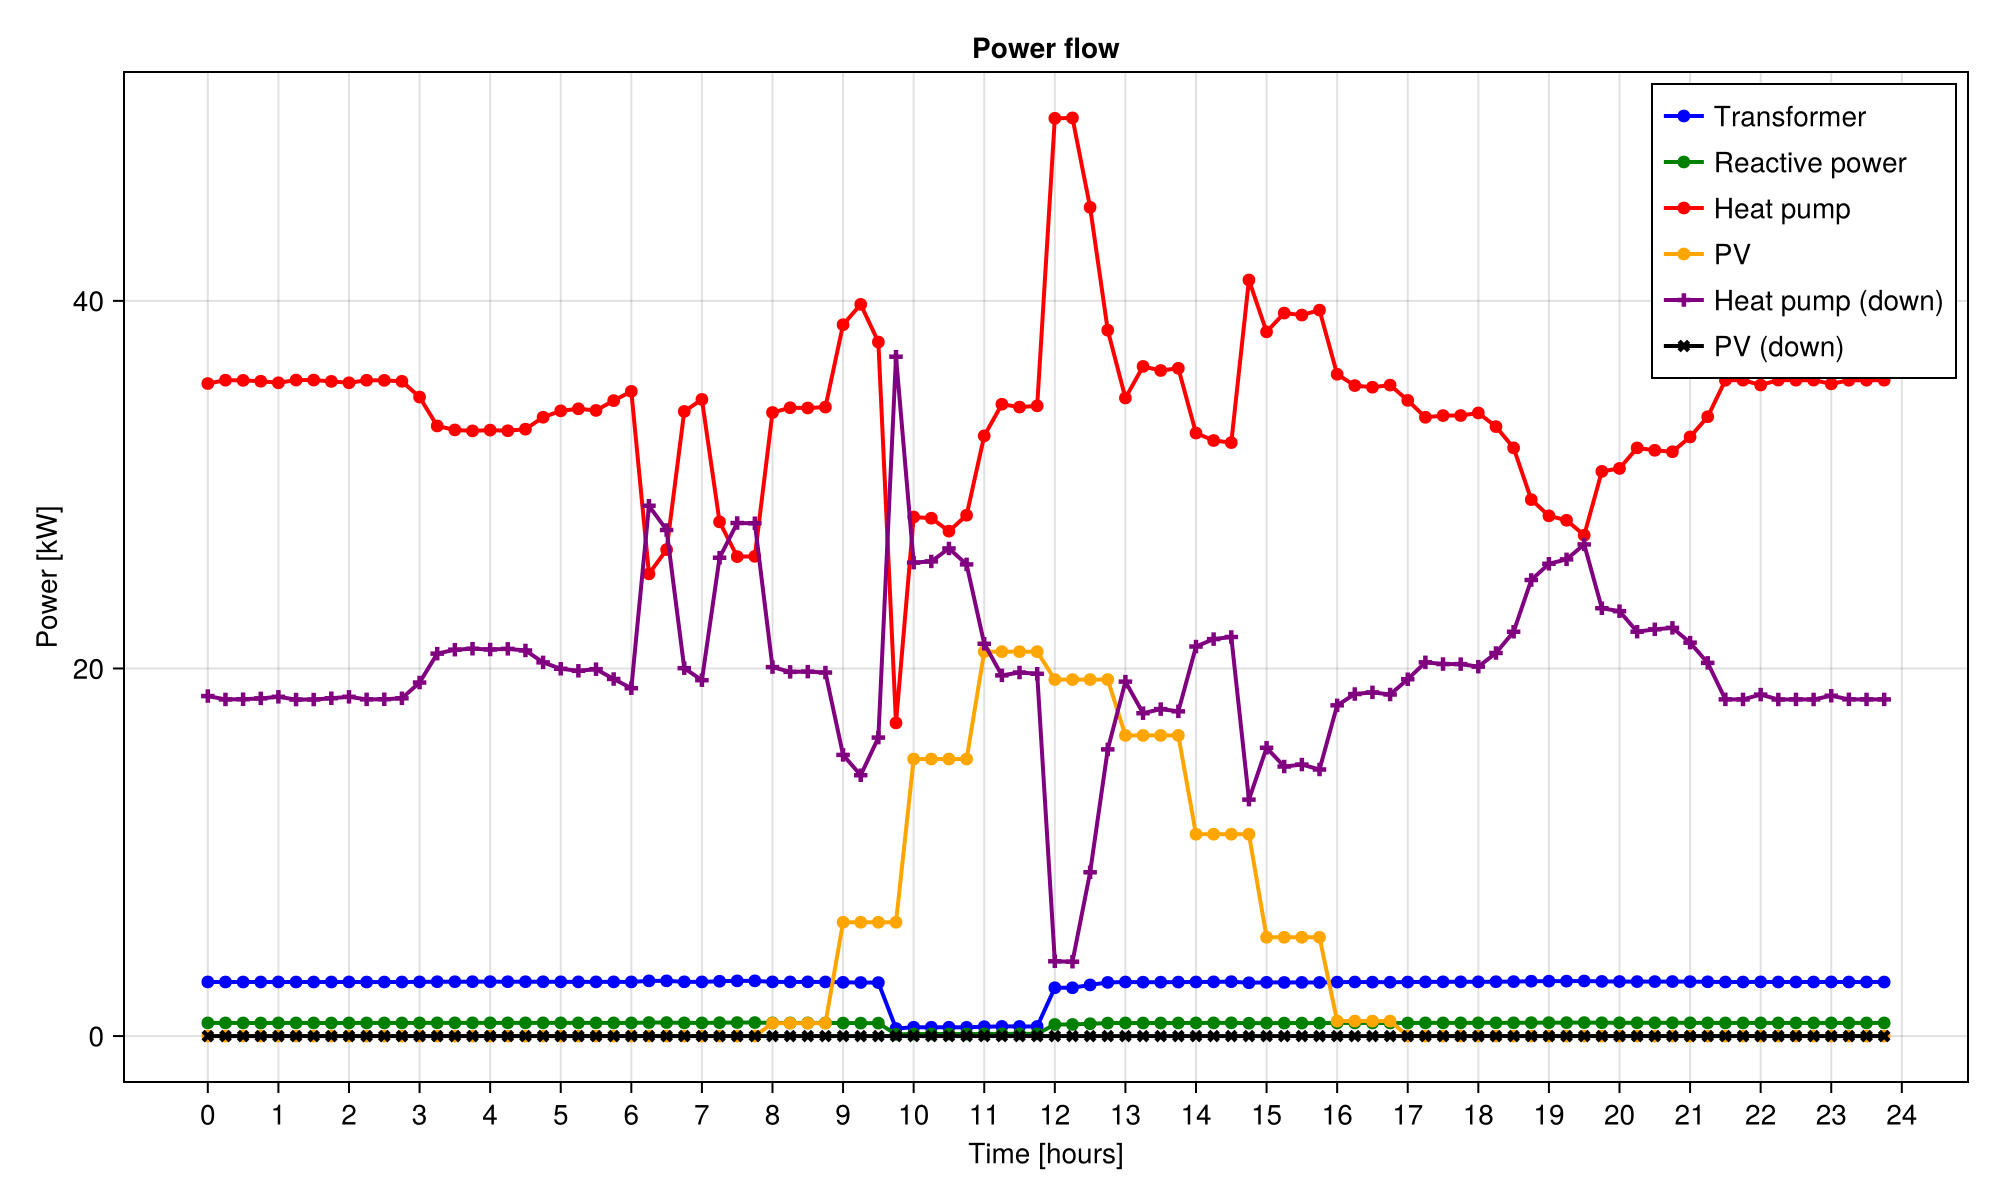

In [ ]:
sol = prepare_solution(model)

# plot using Makie
fig = Figure(; size = (1000, 600))
ax = Axis(fig[1, 1], xlabel = "Time [hours]", 
    ylabel = "Power [kW]", 
    title = "Power flow",
    xticks = (1:4:97, string.(0:1:24))
)

# lines!(ax, sol[:P], color = :blue, label = "Transformer", linestyle = :so
scatterlines!(ax, sol[:P], color = :blue, label = "Transformer", linewidth = 2)
# scatterlines!(ax, sol[:Q], color = :green, label = "Reactive power", linewidth = 2)
scatterlines!(ax, sol[:P_hp], color = :red, label = "Heat pump", linewidth = 2)
scatterlines!(ax, sol[:P_pv], color = :orange, label = "PV", linewidth = 2)
scatterlines!(ax, sol[:P_hp_down], color = :purple, label = "Heat pump (down)", marker=:cross, linewidth = 2)
scatterlines!(ax, sol[:P_pv_down], color = :black, label = "PV (down)", marker=:x, linewidth = 2)
# fig[1, 2] = Legend(fig, ax)
axislegend(ax, merge = true)

# display
fig